# Load the dataset

In [1]:
install.packages("tsibble")
install.packages("feasts")
install.packages("urca")
install.packages("tsibbledata")
install.packages("tseries")
install.packages("forecast")
if (!requireNamespace("fable", quietly = TRUE)) {
  install.packages("fable")
}

if (!requireNamespace("googledrive", quietly = TRUE)) {
  install.packages("googledrive")
}


library(tsibble)
library(feasts)
library(tsibbledata)
library(fable)
library(tidyverse)
library(googledrive)
library(urca)
library(tseries)
library(forecast)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘BH’, ‘anytime’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘quadprog’, ‘distributional’, ‘progressr’, ‘ggdist’, ‘warp’, ‘fabletools’, ‘slider’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘zoo’, ‘quantmod’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibb

In [6]:
# Authenticate Google Drive
drive_auth()

The googledrive package is requesting access to your Google account.
Enter '1' to start a new auth process or select a pre-authorized account.
1: Send me to the browser for a new auth process.
2: giwrgoskakepakis@gmail.com


Selection: 1


Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=d2fe3511b504f3d5ab815736b7a3ac88&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQVNWZ2kzSVloelMyTkJlMnMtS2RKRGlYUTZmWHhCbVZ4dE9Nb2htcEp6X1VPaFF4YnlNT0c1RF8wdWtsOGlhZHVzYXNGdyIsInN0YXRlIjoiZDJmZTM1MTFiNTA0ZjNkNWFiODE1NzM2YjdhM2FjODgifQ==


In [9]:
# List files and locate the folder
files <- drive_ls(path = "Statistics_Final_Project_Kakep")

# Download the dataset to the Colab working directory
drive_download(
  file = "Statistics_Final_Project_Kakep/webtraffic.csv",
  path = "webtraffic.csv",
  overwrite = TRUE
)

# Load the dataset
webtraffic_data <- read.csv("webtraffic.csv")
head(webtraffic_data)

File downloaded:

• webtraffic.csv <id: 1De8D0ChGFb8yqjduqyXE4xdDeD5wxYML>

Saved locally as:

• webtraffic.csv



,Hour.Index,Sessions
,<int>,<dbl>
1,0,1418159421
2,1,1113769116
3,2,919158921
4,3,822352824
5,4,735526737
6,5,798400800


In [10]:
class(webtraffic_data)

[1] "data.frame"

In [11]:
webtraffic_tsibble = as_tsibble(webtraffic_data, index = Hour.Index)
class(webtraffic_tsibble)

[1] "tbl_ts"     "tbl_df"     "tbl"        "data.frame"

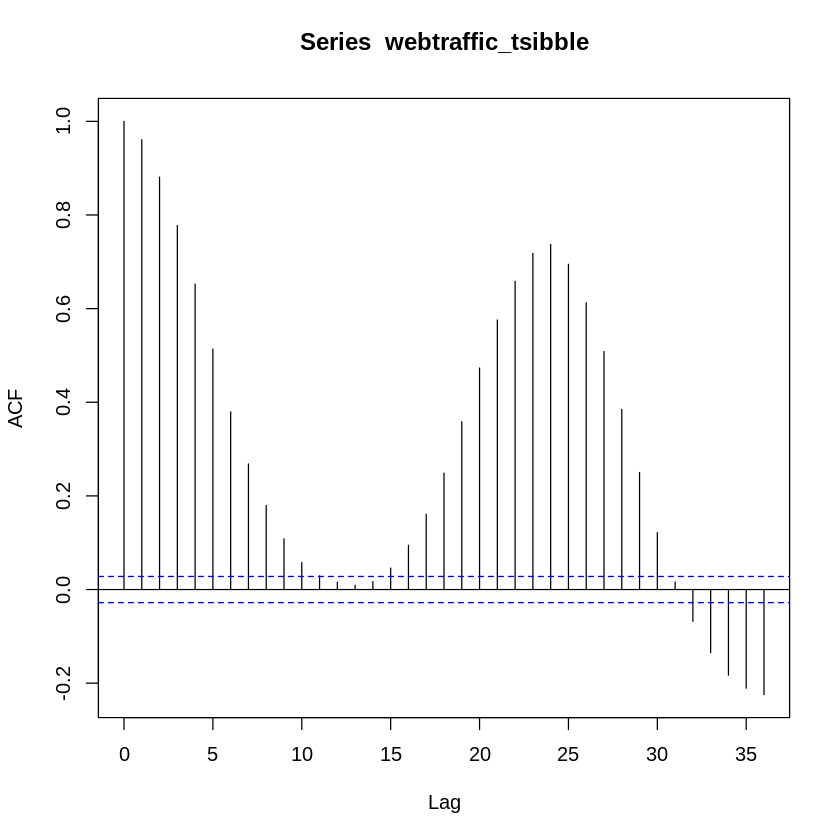

In [12]:
acf(webtraffic_tsibble)

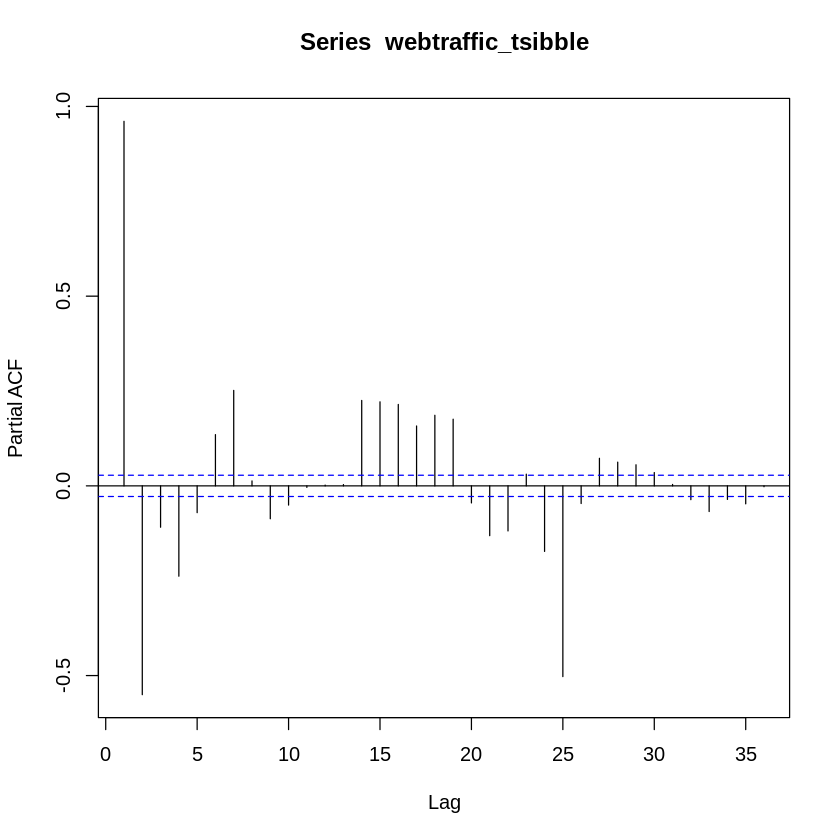

In [13]:
pacf(webtraffic_tsibble)

# Check stationarity

In [14]:
# perfrom KPSS Test to check for stationarity
webtraffic_tsibble %>%
features(Sessions, unitroot_kpss)

kpss_stat,kpss_pvalue
<dbl>,<dbl>
1.033996,0.01


The data is not stationary so we have to differentiate it

# Differentiate manually to make stationary (d = 1)

In [15]:
data_diff <- webtraffic_tsibble %>%
  mutate(diff_sessions = difference(Sessions)) %>%
  filter(!is.na(diff_sessions))
head(data_diff)

Hour.Index,Sessions,diff_sessions
<int>,<dbl>,<dbl>
1,1113769116,-304390305
2,919158921,-194610195
3,822352824,-96806097
4,735526737,-86826087
5,798400800,62874063
6,895206897,96806097


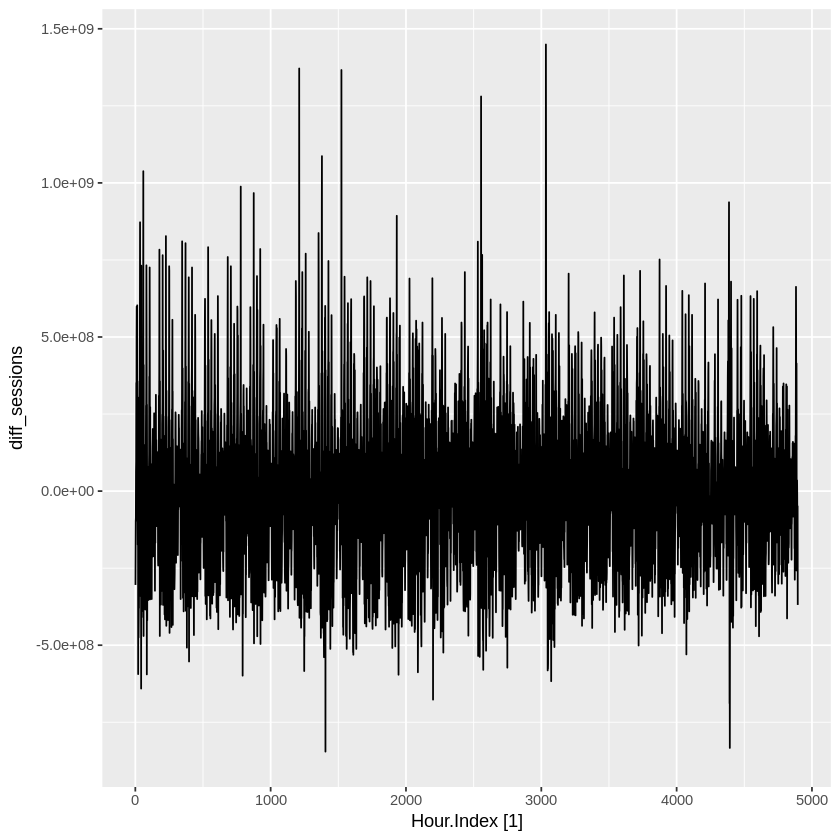

In [16]:
autoplot(data_diff, .vars = diff_sessions)

In [17]:
# perfrom KPSS Test to check for stationarity again
data_diff %>%
features(diff_sessions, unitroot_kpss)

kpss_stat,kpss_pvalue
<dbl>,<dbl>
0.001623271,0.1


The data is now stationary after we differentiate it once

# Split data to train/test

In [18]:
test_size <- 24
train_size <- nrow(webtraffic_tsibble) - test_size

# split to tsibble objects
train_data <- webtraffic_tsibble[1:train_size, ]
test_data <- webtraffic_tsibble[(train_size + 1):nrow(webtraffic_tsibble), ]

# turn to ts() objects
train_ts <- ts(train_data$Sessions, start = c(1, 1), frequency = 24)
test_ts <- ts(test_data$Sessions, start = c(1, 1), frequency = 24)

Plot variable not specified, automatically selected `.vars = Sessions`


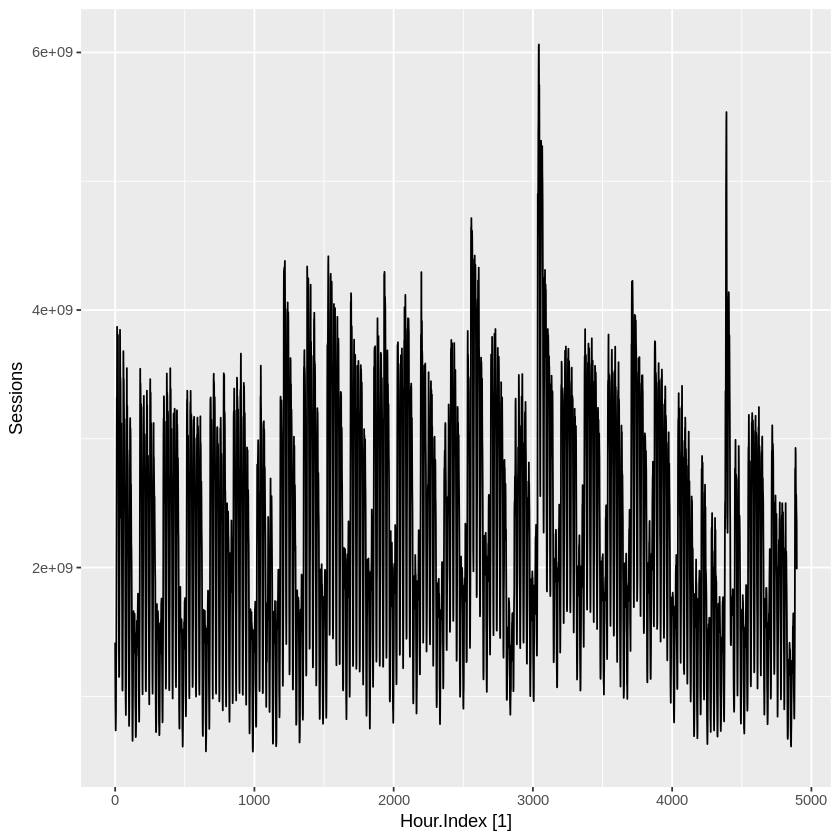

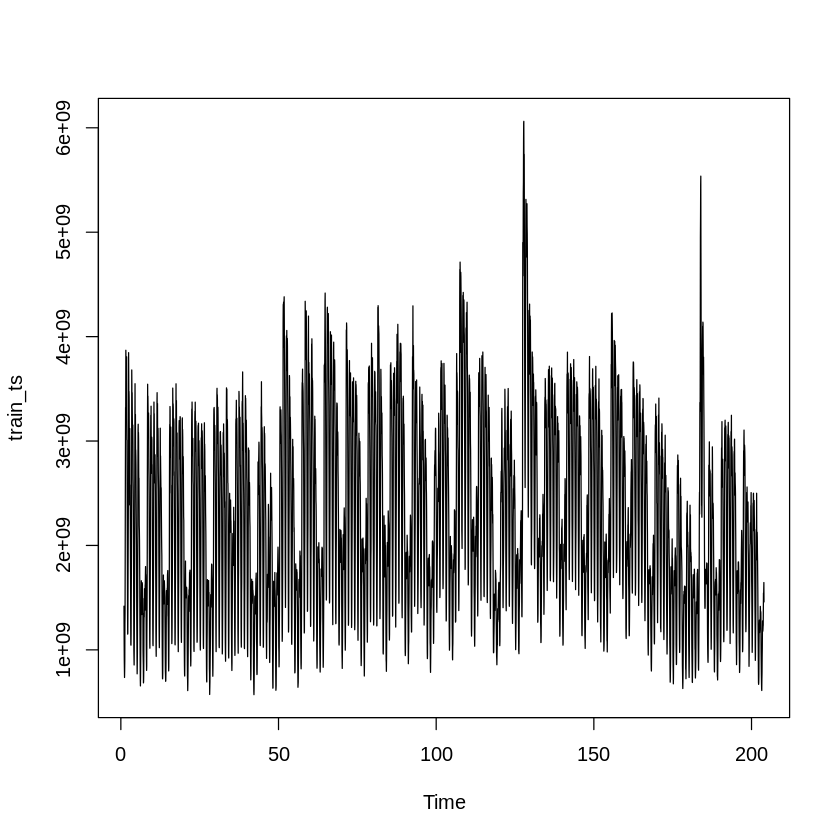

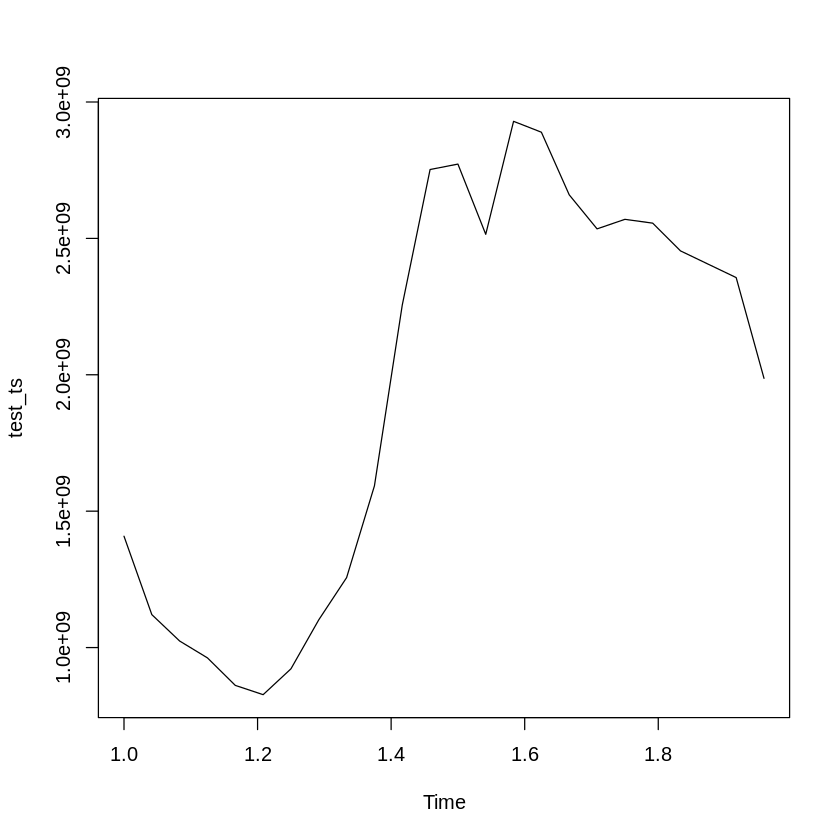

In [19]:
autoplot(webtraffic_tsibble)
plot(train_ts)
plot(test_ts)

# Find optimal lags / seasonality of time series

Dominant frequency:  0.04187947 


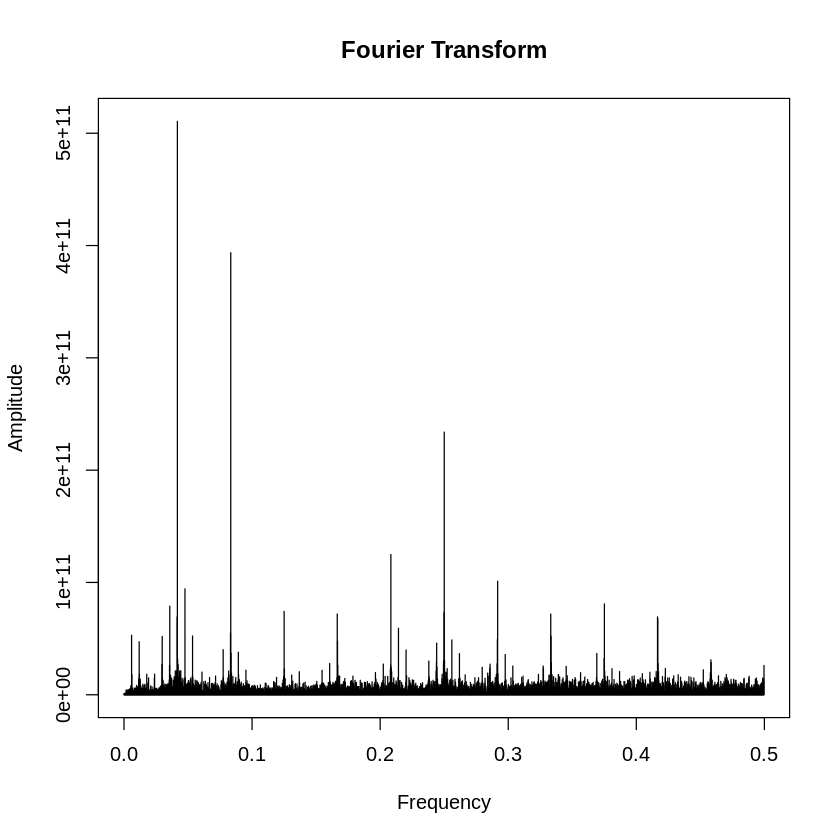

In [20]:
fft_result <- abs(fft(data_diff$diff_sessions))
frequencies <- seq(0, (length(data_diff$diff_sessions) / 2) -1, by = 1) / length(data_diff$diff_sessions)
dominant_frequency <- which.max(fft_result[1:(length(data_diff$diff_sessions) / 2)]) / length(data_diff$diff_sessions)
cat("Dominant frequency: ", dominant_frequency, "\n")
plot(frequencies, fft_result[1:(length(data_diff$diff_sessions) / 2)], type = "h",
     main = "Fourier Transform", xlab = "Frequency", ylab = "Amplitude")

# train ARIMA model

In [21]:
# Load the forecast package
library(forecast)

arima_model <- Arima(train_ts, order = c(5, 1, 2))

In [22]:
arima_model

Series: train_ts 
ARIMA(5,1,2) 

Coefficients:
         ar1      ar2     ar3      ar4      ar5      ma1      ma2
      1.2295  -0.3465  0.1774  -0.0579  -0.1908  -0.8721  -0.0276
s.e.  0.0464   0.0628  0.0301   0.0254   0.0194   0.0457   0.0422

sigma^2 = 3.883e+16:  log likelihood = -99940.36
AIC=199896.7   AICc=199896.7   BIC=199948.6

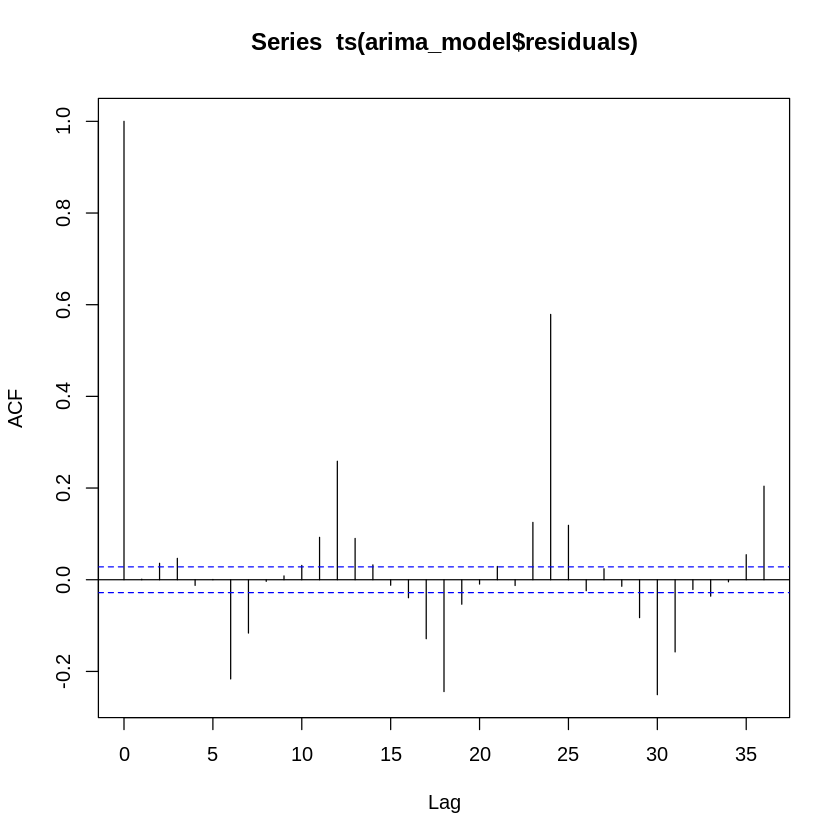

In [23]:
acf(ts(arima_model$residuals))

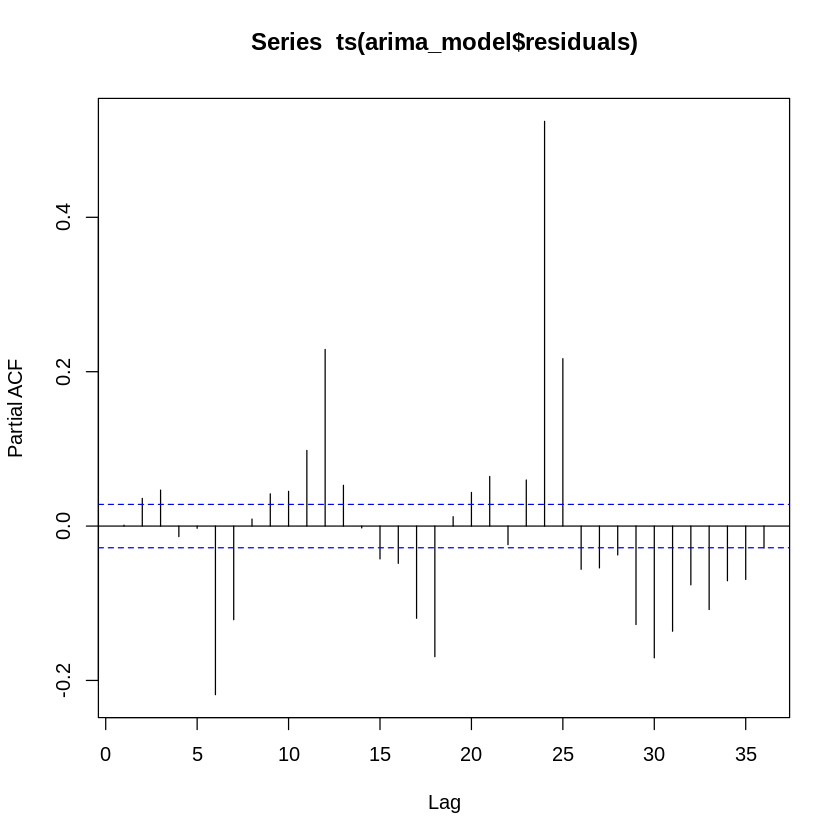

In [24]:
pacf(ts(arima_model$residuals))

# forecast ARIMA model

In [25]:
forecast_arima <- forecast(arima_model, h = length(test_ts))
forecast_arima_ts <- ts(forecast_arima$mean, start = c(1, 1), frequency = 24)

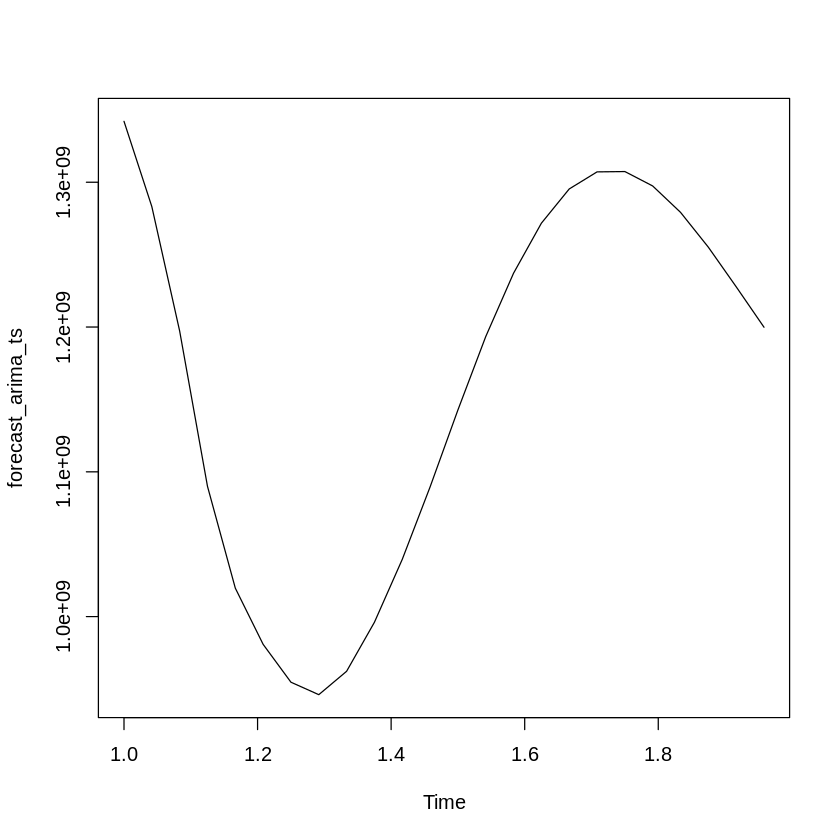

In [26]:
plot(forecast_arima_ts)

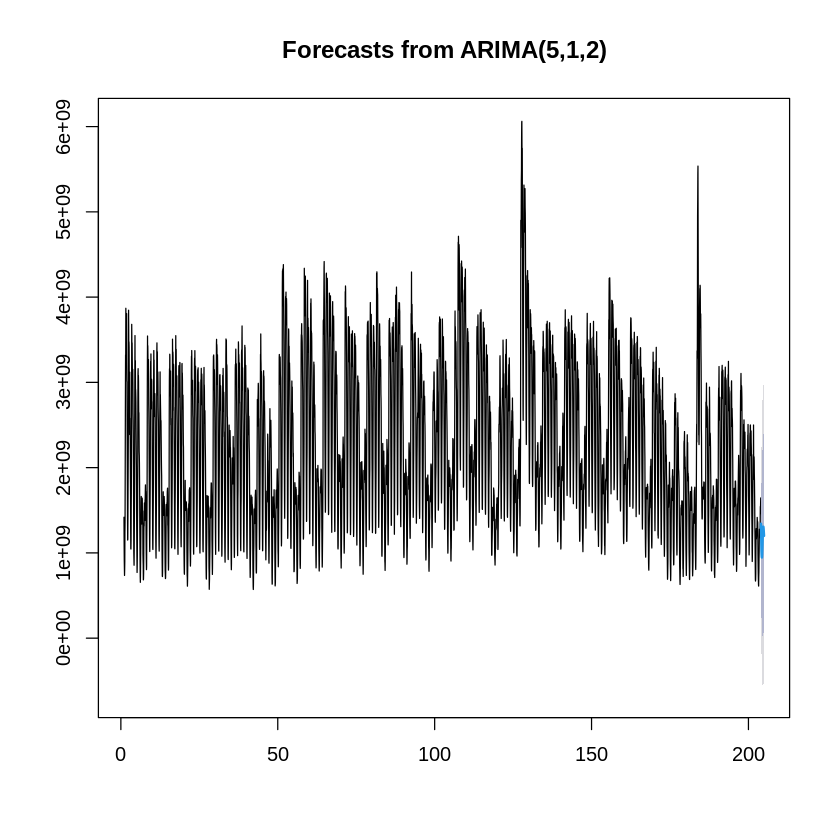

In [27]:
plot(forecast_arima)

# Evaluate ARIMA model

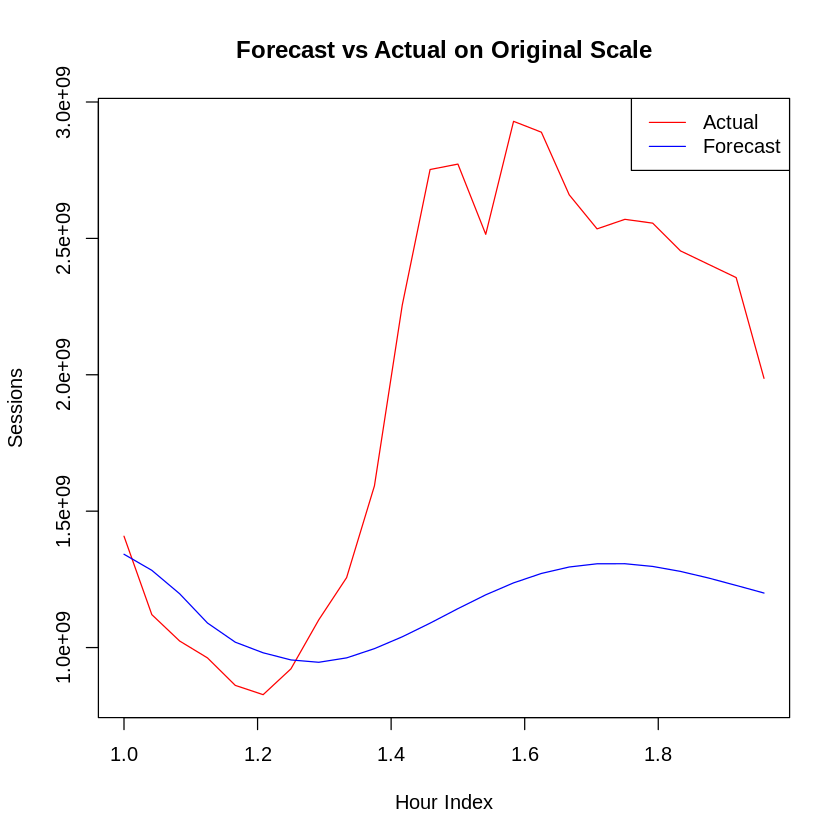

In [28]:
# Plot predicted VS test data
plot(test_ts, type = "l", col = "red",
     xlab = "Hour Index", ylab = "Sessions",
     main = "Forecast vs Actual on Original Scale")
lines(forecast_arima_ts, col = "blue")
legend("topright", legend = c("Actual", "Forecast"), col = c("red", "blue"), lty = 1)

In [29]:
accuracy_arima <- accuracy(forecast_arima_ts, test_ts)
accuracy_arima

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,783248236,1038057215,850583967,29.80101,36.89941,0.9209482,3.025607


In [30]:
print(AIC(arima_model))
print(BIC(arima_model))

[1] 199896.7
[1] 199948.6



	Ljung-Box test

data:  Residuals from ARIMA(5,1,2)
Q* = 5407.1, df = 41, p-value < 2.2e-16

Model df: 7.   Total lags used: 48



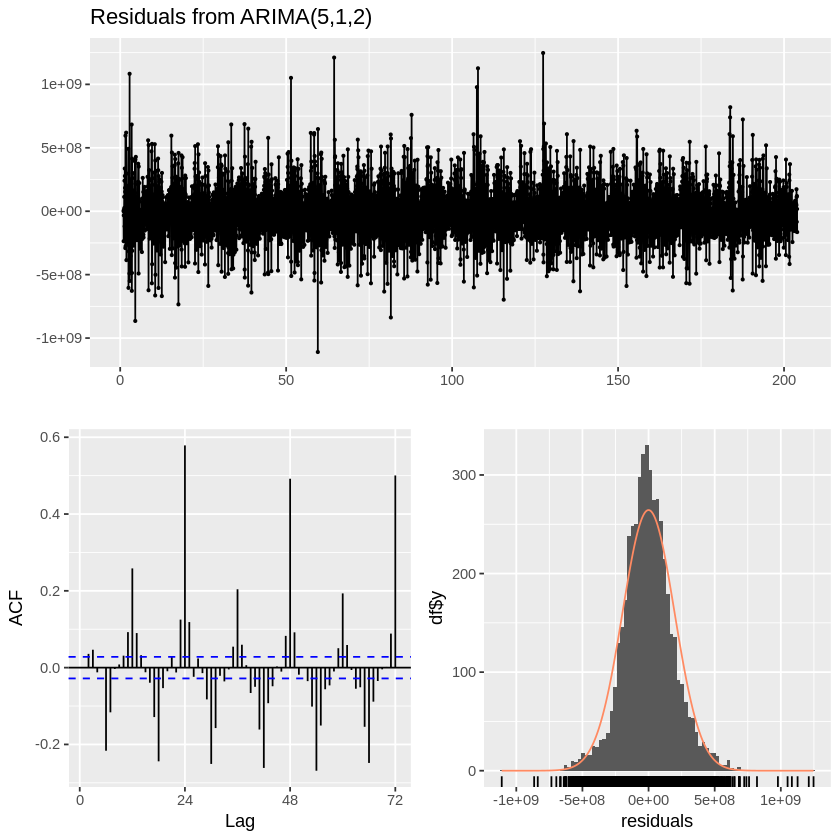

In [31]:
checkresiduals(arima_model)

# train SARIMA model

In [32]:
library(forecast)

arima_model <- Arima(train_ts, order = c(1, 1, 1), seasonal = list(order = c(2, 1, 1), period = 24))

In [33]:
arima_model

Series: train_ts 
ARIMA(1,1,1)(2,1,1)[24] 

Coefficients:
         ar1      ma1    sar1     sar2     sma1
      0.7236  -0.6420  0.1622  -0.1256  -0.9539
s.e.  0.0347   0.0375  0.0149   0.0150   0.0045

sigma^2 = 1.615e+16:  log likelihood = -97350.14
AIC=194712.3   AICc=194712.3   BIC=194751.2

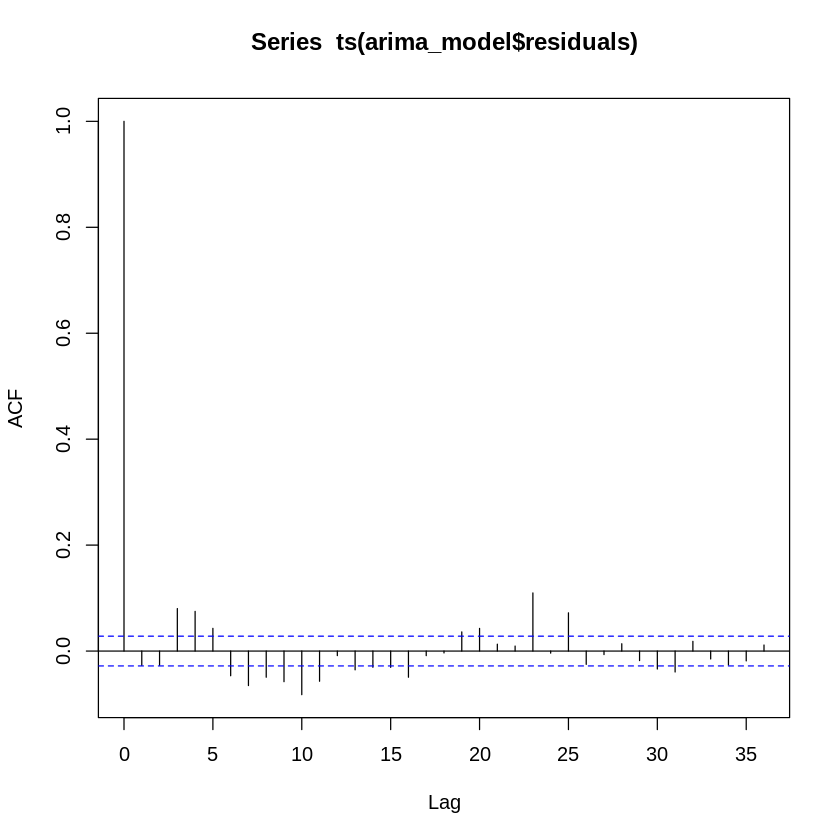

In [34]:
acf(ts(arima_model$residuals))

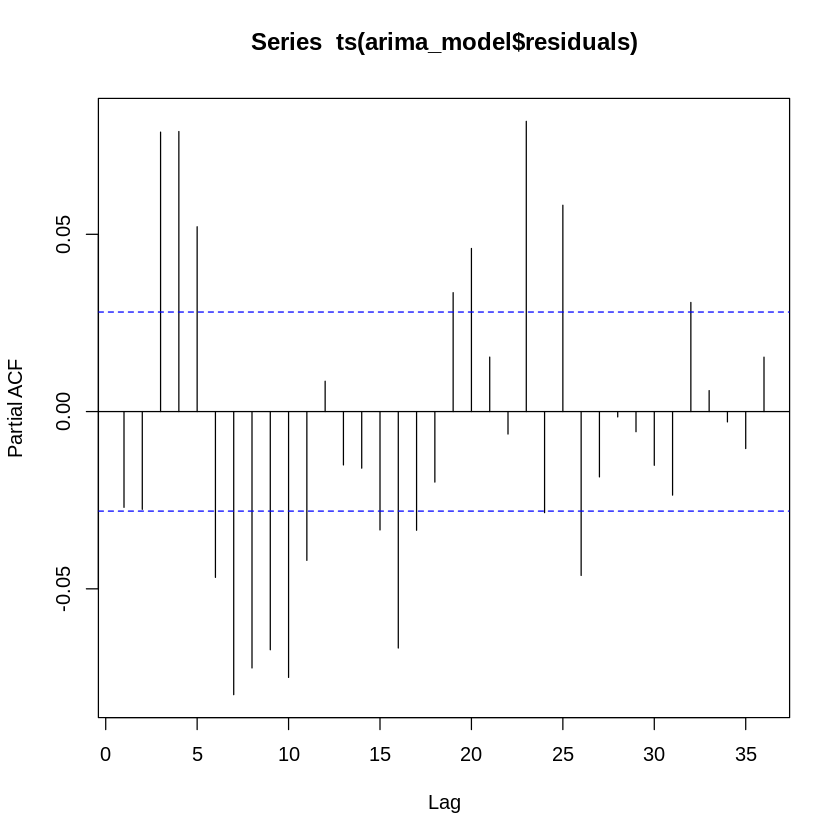

In [35]:
pacf(ts(arima_model$residuals))

# forecast SARIMA model

In [36]:
forecast_arima <- forecast(arima_model, h = length(test_ts))
forecast_arima_ts <- ts(forecast_arima$mean, start = c(1, 1), frequency = 24)

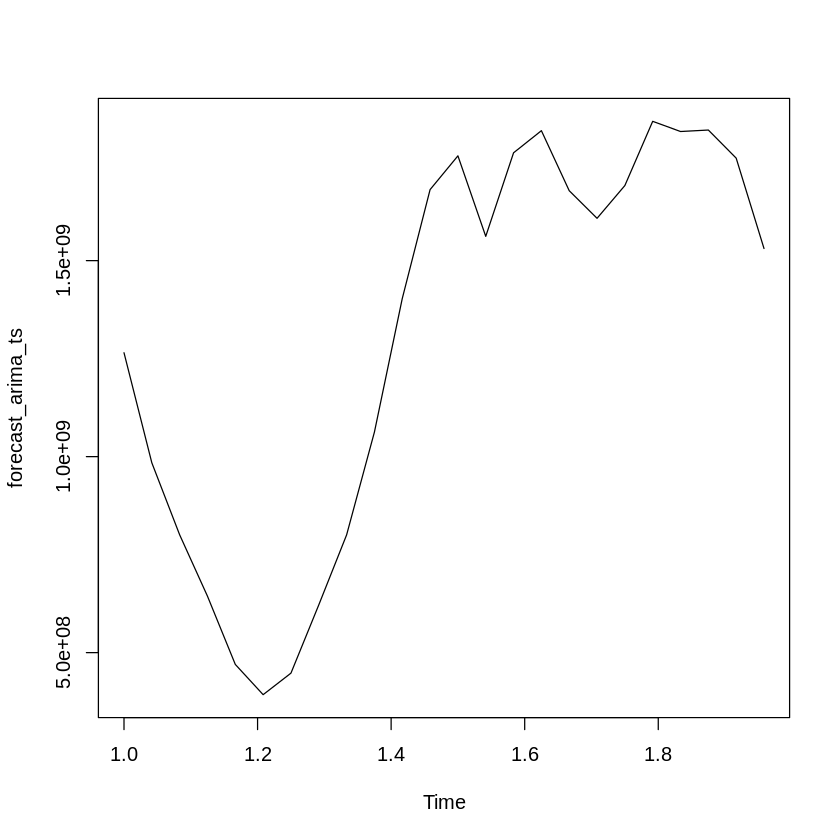

In [37]:
plot(forecast_arima_ts)

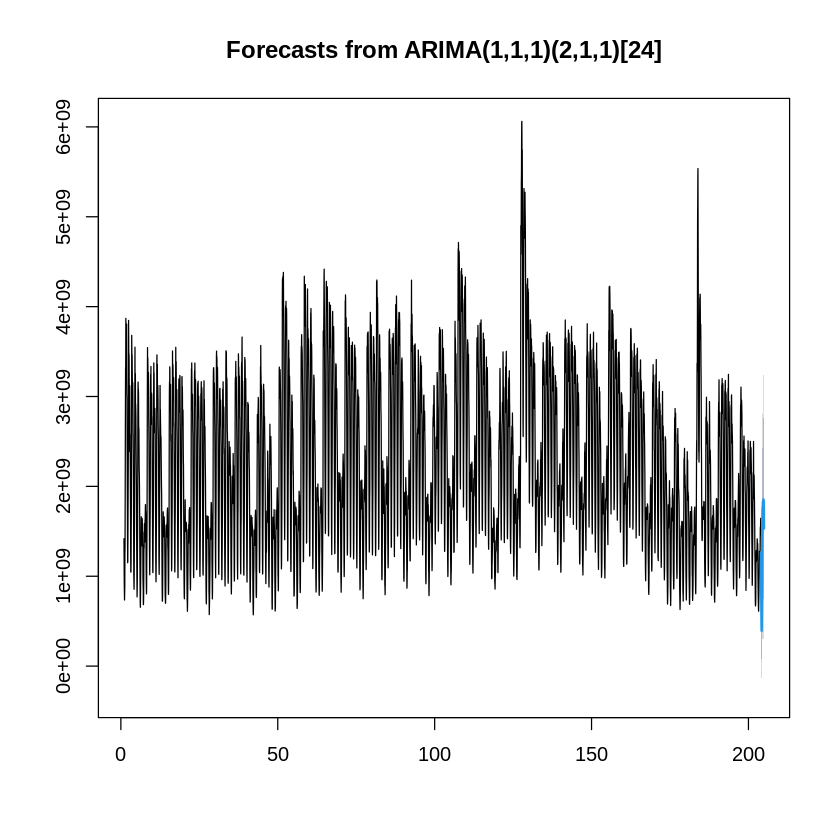

In [38]:
plot(forecast_arima)

# Evaluate SARIMA model

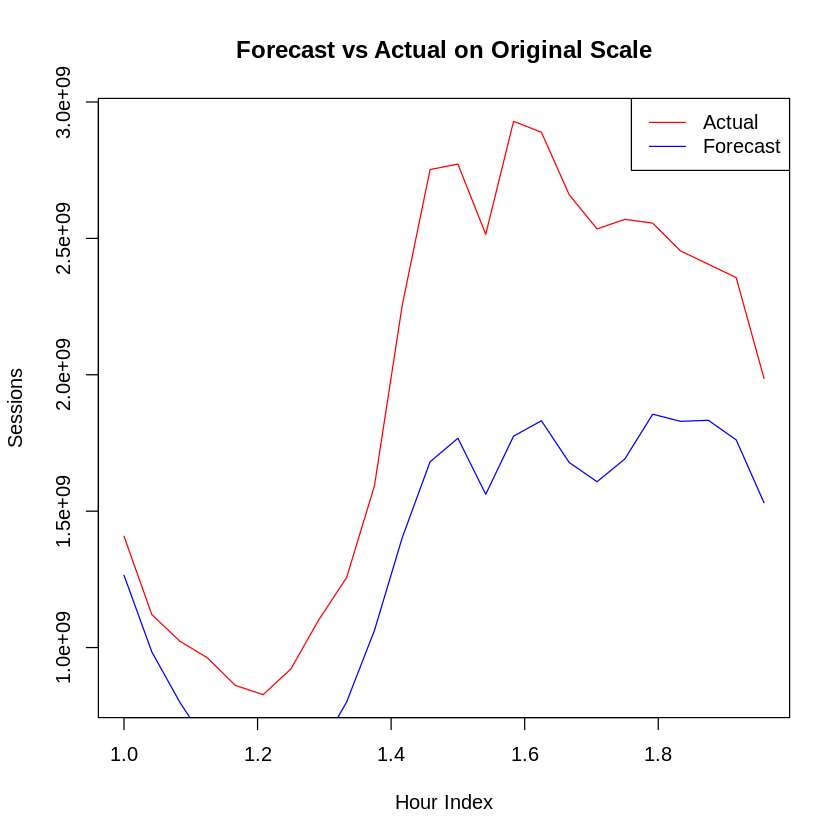

In [39]:
# Plot predicted VS test data
plot(test_ts, type = "l", col = "red",
     xlab = "Hour Index", ylab = "Sessions",
     main = "Forecast vs Actual on Original Scale")
lines(forecast_arima_ts, col = "blue")
legend("topright", legend = c("Actual", "Forecast"), col = c("red", "blue"), lty = 1)

In [40]:
accuracy_arima <- accuracy(forecast_arima_ts, test_ts)
accuracy_arima

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,642322923,709555297,642322923,33.29715,33.29715,0.8636334,2.551914


In [41]:
print(AIC(arima_model))
print(BIC(arima_model))

[1] 194712.3
[1] 194751.2



	Ljung-Box test

data:  Residuals from ARIMA(1,1,1)(2,1,1)[24]
Q* = 384.6, df = 43, p-value < 2.2e-16

Model df: 5.   Total lags used: 48



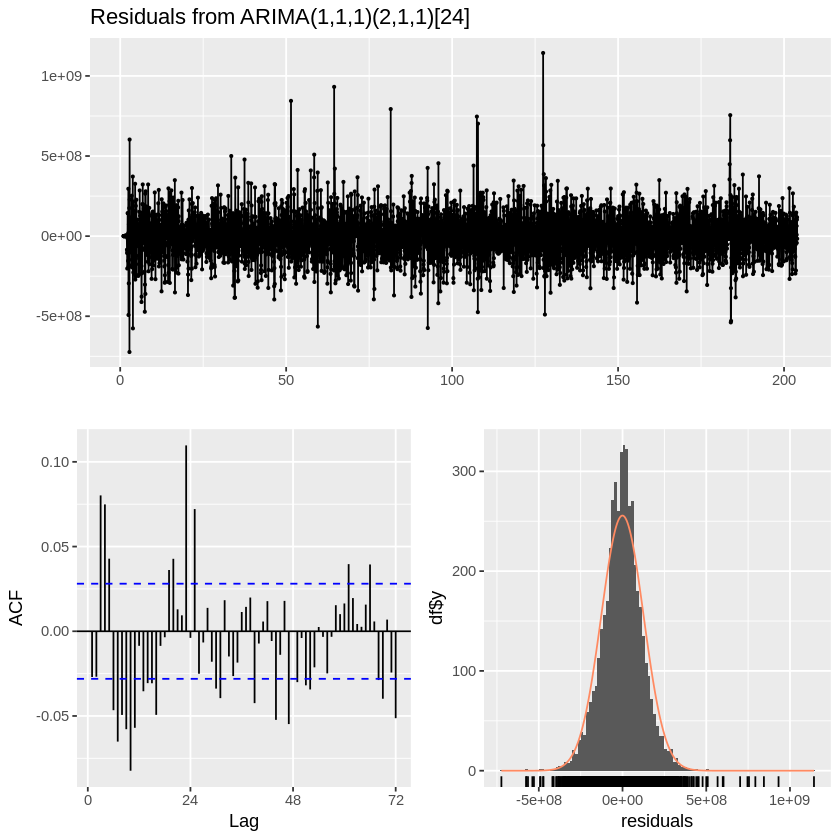

In [42]:
checkresiduals(arima_model)